### This notebook is in mypycaret environment to test the models for BigG_express data using the data merged df that were craeted in the previous notebook

In [1]:
#Libraries need for work

import pandas as pd
from datetime import datetime, timedelta



from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#we need to create a conda environment for pycaret and then pip install the packages after activating and rerun the notebook.
from pycaret.classification import *
from pycaret.regression import *
from pycaret.time_series import *

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
faults_clean = pd.read_csv("../data/faults_clean.csv")

In [6]:
derate_feature = pd.read_pickle('../data/derate_features.pk')

In [5]:
derate_target = pd.read_pickle('../data/derate_target.pk')

In [7]:
derate_target.shape #(546674, 2)

(546674, 2)

In [10]:
derate_feature.shape #(546674, 461)

(546674, 461)

In [27]:
derate_feature.info()
derate_feature.columns.to_series().groupby(derate_feature.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546674 entries, 536775 to 70148
Columns: 461 entries, RecordID to target
dtypes: bool(1), datetime64[ns](2), float64(419), int32(1), int64(6), object(32)
memory usage: 1.9+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [49]:
derate_feature['MCTNumber'].isna().sum()

0

In [33]:
# derate_feature.columns.to_list()


In [53]:
#how to find a column where a particula string exists
# word = 'Low (Severity Low) Engine Coolant Level' #this string is causing problem which is present in event description so going to drop that column as well
word = 'unknown'
derate_feature.columns[derate_feature[derate_feature==word].notna().sum()>0][0]

'ecuSoftwareVersion'

In [61]:
# X = derate_feature.drop(columns=['EquipmentID_y', 'eventDescription', 'ecuSoftwareVersion', 'active',
#                                  'ecuModel', 'ecuMake', 'activeTransitionCount', 'EquipmentID_x',
#                                  'MCTNumber', 'SPN_FMI', 'EquipmentID_y', 'spn_fmi','EventTimeStamp',
# 'Latitude',
#  'Longitude',
#  'LocationTimeStamp',
#  'SPN_FMI',
#  'target'])

X= derate_feature[['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 
                'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',]]
y = derate_feature[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

# linreg_base = LinearRegression().fit(X_train_sm1, y_train_sm1)# 

# X_train_added2.columns
# X_train_added2.head(10)

In [62]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(410005, 21)
(136669, 21)
(136669, 1)


In [63]:
from sklearn.impute import SimpleImputer
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train, y_train)

In [64]:
# fit the model on X_test data
logreg1 = logReg_scaler.predict(X_test)

In [65]:
#finding the accuracy score

accuracy_score(y_test, logreg1)

0.9971902918730656

In [72]:
pd.DataFrame({'feature': logReg_scaler['impute'].get_feature_names_out(),
                             'coefficient': logReg_scaler['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

,feature,coefficient,ex_coefficient
8,EngineRpm,-0.395508,0.673338
1,BarometricPressure,-0.283382,0.753232
6,EngineOilPressure,-0.242197,0.784902
14,IntakeManifoldTemperature,-0.165102,0.847807
11,FuelLtd,-0.075440,0.927336
10,FuelLevel,-0.055616,0.945902
4,EngineCoolantTemperature,-0.033965,0.966606
0,AcceleratorPedal,-0.018691,0.981482
7,EngineOilTemperature,-0.010503,0.989552
17,Speed,-0.009411,0.990633


In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [115]:
confusion_matrix(y_test, logReg_scaler.predict(X_test))

array([[136285,      2],
       [   382,      0]], dtype=int64)

In [116]:
from cm import plot_confusion_matrix

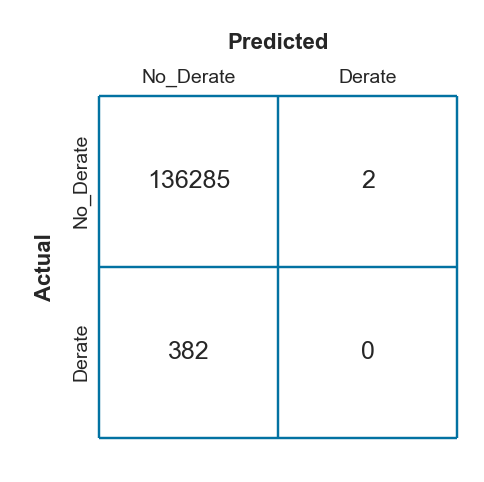

In [117]:
plot_confusion_matrix(y_test, logReg_scaler.predict(X_test), labels = ['No_Derate', 'Derate']);

In [122]:
# ConfusionMatrixDisplay(y_test, logReg_scaler.predict(X_test), labels = ['No_Derate', 'Derate']); #this is not working

cm = confusion_matrix(y_train, logreg1, labels=["O", "A"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [410005, 136669]

In [77]:
from sklearn.metrics import roc_auc_score

In [78]:
roc_auc_score(y_test, logReg_scaler.predict_proba(X_test)[:,1] )

0.8525730675299205

In [95]:
derate_feature['EquipmentID_x'].nunique() #1042
derate_feature.loc[derate_feature['target']==1]['EquipmentID_x'].nunique() #189
deartae_trucks = derate_feature.loc[derate_feature['target']==1]['EquipmentID_x'].unique()
all_trucks = derate_feature['EquipmentID_x'].unique()

no_derate = all_trucks[np.isin(all_trucks, deartae_trucks, invert=True)]

len(no_derate) #853
# derate_feature.loc[derate_feature['target']==0]['EquipmentID_x'].nunique()

853

In [104]:
174932+371742

546674

In [103]:
df_derate = derate_feature[(derate_feature['EquipmentID_x'].isin(deartae_trucks))]
df_derate.shape #(174932, 461)

(174932, 461)

In [102]:
df_no = derate_feature[(derate_feature['EquipmentID_x'].isin(no_derate))] #371742 rows × 461 columns

In [105]:
df_derate.head()

,RecordID,spn,fmi,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,...,spn_94,spn_940,spn_941,spn_95,spn_96,spn_97,spn_976,spn_98,spn_fmi,target
444126,1248431,96,3,0.0,14.645,66.48672,443434.9,186.8,12.0,22.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,96_3,0
444127,1248432,829,3,0.0,14.645,66.48672,443434.9,186.8,12.0,22.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,829_3,0
444128,1248425,829,3,0.0,14.645,66.48672,443434.3,185.0,17.0,22.04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,829_3,0
444129,1248426,96,3,0.0,14.645,66.48672,443434.3,185.0,17.0,22.04,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,96_3,0
444130,1248394,96,3,0.0,14.645,66.48672,443424.0,185.0,12.0,24.94,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,96_3,0


In [109]:
X = df_derate.drop(columns=['target'])
y= df_derate[['target']]

X_train_derate, X_test_derate, y_train_derate, y_test_derate = train_test_split(X, y, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X_train_derate.shape)
print(X_test_derate.shape)
print(y_train_derate.shape)
print(y_test_derate.shape)

(139945, 460)
(34987, 460)
(139945, 1)
(34987, 1)


In [111]:
X_no = df_no.drop(columns=['target'])
y_no= df_no[['target']]

X_train_noderate, X_test_noderate, y_train_noderate, y_test_noderate = train_test_split(X_no, y_no, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X_train_noderate.shape)
print(X_test_noderate.shape)
print(y_train_noderate.shape)
print(y_test_noderate.shape)

(297393, 460)
(74349, 460)
(297393, 1)
(74349, 1)


In [132]:
# df = all_trucks[~all_trucks[['EquipmentID']].isin(derate_trucks).any(axis=1)]
# pd.concat([data1, data2], axis=0)

X_train1 = pd.concat([X_train_derate, X_train_noderate], axis=0) #437338 rows × 460 columns

X_test1 = pd.concat([X_test_derate, X_test_noderate], axis=0) #109336 rows × 460 columns

y_train1 = pd.concat([y_train_derate, y_train_noderate], axis=0) #437338 rows × 1 columns

y_test1 = pd.concat([y_test_derate, y_test_noderate], axis=0) #109336 rows × 1 columns

In [135]:
#cases take out due to 25% or more missing values
y_train1['target'].value_counts()

0    436221
1      1117
Name: target, dtype: int64

In [123]:
# #finding which feature is helping the most in prediction

# cm=confusion_matrix(y_true, y_pred, labels=["O", "A"])
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()

In [136]:
pip install imblearn

In [137]:
from imblearn.over_sampling import SMOTE

In [142]:
oversampler = SMOTE(k_neighbors=5, random_state=42)
X_smote, y_smote = oversampler.fit_resample(X_train1, y_train1)
y_smote.value_counts()

ValueError: could not convert string to float: 'Abnormal Update Rate Tire Location'

In [ ]:
oversampler = SMOTE(k_neighbors=5, random_state=42)
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)
y_smote.value_counts()
gbr_smoted = Pipeline(
    steps = [
        ('gb', GradientBoostingClassifier(verbose=True))#n_estimators = 1000, learning_rate=0.01
    ]
)

gbr_smoted.fit(X_smote, y_smote)
y_predict = gbr_smoted.predict(X_train)
confusion_matrix(y_train, y_predict)
confusion_matrix(y_test, gbr.predict(X_test))
confusion_matrix(y_test, gbr_smoted.predict(X_test))
print(classification_report(y_train, y_predict))

In [141]:
from sklearn.impute import SimpleImputer
 
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
#         ('smote', SMOTE(k_neighbors=5, random_state=42)),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train1, y_train1)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Abnormal Update Rate Tire Location'